In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import nltk
import math
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
%matplotlib inline

In [2]:
# Part 1

hackernews_items = pd.read_csv('hn_items.csv',delimiter=',',encoding='latin-1')

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bepis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
model = SentimentIntensityAnalyzer()

hn_text = hackernews_items.dropna(subset=['text'], how='all')['text'].values

df = pd.DataFrame(columns=['text','neg','pos'])

data = []

for text in hn_text:
    score = model.polarity_scores(text)
    
    data.append({'text':text,'neg':score['neg'],'pos':score['pos']})
    

df = df.append(data)

df.head(5)

,text,neg,pos
0,&#34;the rising star of venture capital&#34; -...,0.0,0.000
1,Is there anywhere to eat on Sandhill Road?,0.0,0.000
2,It's kind of funny that Sevin Rosen is giving ...,0.0,0.218
3,"This is interesting, but the limitations becom...",0.0,0.149
4,Stay tuned...,0.0,0.000


In [4]:
print('5 most positive: ')
print(df.nlargest(5,'pos'))

print('5 most negative: ')
print(df.nlargest(5,'neg'))

5 most positive: 
                text  neg  pos
605             sure  0.0  1.0
999              ha!  0.0  1.0
1307      Beautiful.  0.0  1.0
1628  Great, thanks!  0.0  1.0
1902            True  0.0  1.0
5 most negative: 
             text  neg  pos
512          dupe  1.0  0.0
1797         spam  1.0  0.0
2962          No.  1.0  0.0
3008       dupe.   1.0  0.0
3014  desperation  1.0  0.0


In [5]:
# Part 2

negatives = df['neg']
positives = df['pos']
posts = hackernews_items.dropna(subset=['text'], how='all')['text']

0.0254722445297
0.0356773694295
0.0183918469091
0.0322194681288
0.031665467571
0.0155339841288
0.0379781367887
0.0238365963671
0.018712641172
0.012070582062


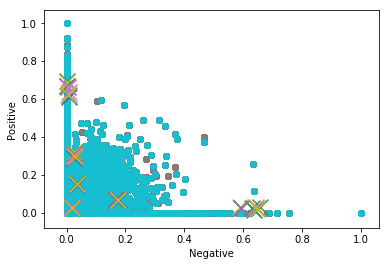

In [89]:
# No idea if this is right or not, doesn't feel like there's anywhere that can properly inform how this is supposed to work.
# Would like a little more information on how this KMeans stuff is supposed to be done.
from sklearn.cluster import KMeans
    
folds = KFold(n_splits=10)
kmeans = KMeans(n_clusters=6)

X = negatives.values
Y = positives.values
XY = np.stack((X,Y),axis=1)

for train_idx, test_idx in folds.split(X, Y):
    X_train, X_test = X[train_idx].reshape(-1,1), X[test_idx].reshape(-1,1)
    Y_train, Y_test = Y[train_idx].reshape(-1,1), Y[test_idx].reshape(-1,1)
    XY_fold = XY[train_idx]
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X_train,Y_train)
    
    pred = regr.predict(X_test)
    
    kmeans.fit(XY_fold)
    
    centroid = kmeans.cluster_centers_
    
    plt.scatter(centroid[:,0],centroid[:,1], marker = "x", s=250, linewidths = 5, zorder = 10)
    plt.scatter(X[train_idx],Y[train_idx])

    print(metrics.r2_score(Y_test,pred))
    

plt.xlabel('Negative')
plt.ylabel('Positive')

In [8]:
# Part 3
import folium
from folium.plugins import HeatMap

boliga = pd.read_csv('boliga_zealand.csv').drop(['Index', '_1', 'Unnamed: 0'], axis=1)
zip_df = pd.DataFrame(boliga['zip_code'].str.split(' ',1).tolist(), columns = ['zip','city'])
boliga = boliga.assign(zip_int=zip_df['zip'])
boliga = boliga[boliga['zip_int'].astype(int) <= 2999]
boliga['zip_int'] = pd.to_numeric(boliga['zip_int'], errors='coerce')
heatmap_df = boliga[['lon','lat','price']].dropna()

In [9]:
boliga_map = folium.Map(location=[55.676098, 12.568337], zoom_start=11)

folium.Marker(location=[55.676098, 12.568337], icon=folium.Icon(color='red',icon='home')).add_to(boliga_map)
heat_data = [(e.lat,e.lon,float(e.price)) for e in heatmap_df.itertuples()]

In [10]:
HeatMap(heat_data, radius=7).add_to(boliga_map)

In [11]:
# Jupyter seems unable to properly load the Folium file, so it's saved as a separate file.
boliga_map.save('heatmap.html')

# If price and proximity are the only factors, then western Copenhagen seems to have a significant clustering of low-price housing.
# Particularly, Brønshøj, Husum, Rødovre and Hvidovre have fairly low prices, along with housing along the eastern side of Kalvebod Fælled.
# Northwestern Copenhagen is a generally low-income area, and it seems there is a clear divide in pricing in western copenhagen when moving past Frederiksberg and Valby.
# So while pricing in these areas is low, desirability is also on the lower end. As such, somewhere in Amager south of Kastrup might be more desirable.

In [12]:
# Part 4

haversine_df = boliga.dropna()

import math
def haversine_distance(origin, destination):

    lat_orig, lon_orig = origin
    lat_dest, lon_dest = destination
    radius = 6371

    dlat = math.radians(lat_dest-lat_orig)
    dlon = math.radians(lon_dest-lon_orig)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat_orig)) 
        * math.cos(math.radians(lat_dest)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [13]:
cph_center = (55.676098, 12.568337)

haversine_df = haversine_df.assign(km_to_cph=haversine_df.apply(lambda row: haversine_distance((row['lat'],row['lon']),cph_center),axis=1))
haversine_df[:5]

,address,zip_code,price,sell_date,sell_type,price_per_sq_m,no_rooms,housing_type,size_in_sq_m,year_of_construction,price_change_in_pct,lon,lat,zip_int,km_to_cph
0,"Ved Volden 5, 5. TV",1425 København K,4000000,23-05-2017,Alm. Salg,43956.0,3.0,Lejlighed,91.0,1938.0,0.0,12.593629,55.671769,1425,1.657329
1,"Rådhusstræde 4C, 1",1466 København K,4895000,18-05-2017,Alm. Salg,46619.0,3.0,Lejlighed,105.0,1796.0,0.0,12.573689,55.676839,1466,0.345533
2,"Store Kongensgade 112A, 3",1264 København K,250000,15-05-2017,Andet,1851.0,2.0,Lejlighed,135.0,1860.0,0.0,12.590441,55.687079,1264,1.846924
3,"Amaliegade 13G, 2",1256 København K,7375000,15-05-2017,Alm. Salg,75255.0,3.0,Lejlighed,98.0,1948.0,9.0,12.591287,55.683439,1256,1.654270
4,"Borgergade 144, 3. TH",1300 København K,5825000,10-05-2017,Alm. Salg,57673.0,3.0,Lejlighed,101.0,1854.0,3.0,12.588744,55.687623,1300,1.810790


In [14]:
regr = linear_model.LinearRegression()

X_variables = haversine_df['km_to_cph'].astype(float).values.reshape(-1,1)
Y_variables = haversine_df['price'].astype(int).values.reshape(-1,1)
Z_variables = haversine_df['size_in_sq_m'].astype(float).values.reshape(-1,1)

In [15]:
from math import sqrt

folds = KFold(n_splits=10)

metrics_df = pd.DataFrame(columns=['MAE','RMSE','Pearson','Coefficients','Intercept'])

metrics_list = []

for train_idx, test_idx in folds.split(X_variables, Y_variables, Z_variables):
    XZ_variables = np.stack([X_variables,Z_variables], axis=1).reshape(-1,2)
    XZ_train, XZ_test = XZ_variables[train_idx], XZ_variables[test_idx]
    Y_train, Y_test = Y_variables[train_idx], Y_variables[test_idx]
    
    regr = linear_model.LinearRegression()
    
    regr.fit(XZ_train, Y_train)
    
    pred = regr.predict(XZ_test)
    
    MAE = str(metrics.mean_absolute_error(Y_test,pred))
    RMSE = str(sqrt(metrics.mean_squared_error(Y_test,pred)))
    Pearson = str(metrics.r2_score(Y_test, pred))
    coef = str(regr.coef_)
    intercept = str(regr.intercept_)
    
    metrics_list.append({'MAE':MAE,'RMSE':RMSE,'Pearson':Pearson,'Coefficients':coef,'Intercept':intercept})

metrics_df = metrics_df.append(metrics_list)
    
metrics_df

,MAE,RMSE,Pearson,Coefficients,Intercept
0,1152426.40083,1970456.7520426747,0.2512065009,[[-48927.21917837 21793.73324686]],[ 455465.29648107]
1,1112818.32583,2106341.8782790154,0.199261757978,[[-53526.40667975 22355.32193597]],[ 458735.53624745]
2,1038181.004,1897074.3059717342,0.251317902847,[[-52438.02156827 22178.21591541]],[ 460545.27215071]
3,771534.497978,1289043.8226479038,0.315170363246,[[-54469.47456069 21982.07455104]],[ 520178.48545363]
4,764566.440214,1260824.3848231388,0.348528289165,[[-53797.32561804 21968.40333481]],[ 512492.91450658]
5,832968.95234,1528933.9884076945,0.124404578925,[[-55504.87703858 22406.3758418 ]],[ 512507.20972339]
6,888435.167942,1447408.8861457743,-0.275045379899,[[-48990.29364679 22965.01353961]],[ 435351.81712888]
7,964310.921312,1942942.8956618672,-0.0603884749197,[[-54194.32311668 23143.15452534]],[ 422547.00724831]
8,1120429.70421,1697633.3379646903,0.238370144424,[[-57449.2946725 22483.6835725]],[ 484303.64125984]
9,1576969.84172,3174918.988758466,0.186329439592,[[-65416.53594372 20154.36910224]],[ 699085.39147314]


In [16]:
# As is plainly clear, the model can't help us untuit anything - in some cases it might actually be worse to follow the model than not.
# Size and proximity to the city center are not exactly fully representative - the price variance between several homes of equal size is too huge to be a reliable metric.
# As for proximity; Bispebjerg and Amager Øst are of approximately equal distance to Nørreport, where the former is notoriously low-income, while the latter is notoriously high-income.
# Also, prices have changed drastically over time, as gentrification of certain parts of the city has greatly increased prices of homes in recent years.
# We believe that we would need both a greater dimensionality, as well as data more representative of current prices to accurately intuit prices of homes in the city.

In [17]:
# Part 5
# To see if we're correct in our assumption, we'll increase the dimensionality of the dataset.
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X_boliga = np.array(haversine_df[['price_per_sq_m','no_rooms','year_of_construction','price_change_in_pct','zip_int','lon','lat','km_to_cph']])
Y_boliga = haversine_df['price'].values

X_boliga_scaled = scale(X_boliga)

pca = PCA(n_components=0.95)
pca.fit(X_boliga_scaled)

boliga_transform = pca.transform(X_boliga_scaled)
boliga_transform.shape

(302239, 7)

In [18]:
from math import sqrt

folds = KFold(n_splits=10)

metrics_df = pd.DataFrame(columns=['MAE','RMSE','Pearson','Coefficients','Intercept'])

metrics_list = []

for train_idx, test_idx in folds.split(boliga_transform, Y_boliga):
    X_train, X_test = boliga_transform[train_idx], boliga_transform[test_idx]
    Y_train, Y_test = Y_boliga[train_idx], Y_boliga[test_idx]
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X_train, Y_train)
    
    pred = regr.predict(X_test)
    
    MAE = str(metrics.mean_absolute_error(Y_test,pred))
    RMSE = str(sqrt(metrics.mean_squared_error(Y_test,pred)))
    Pearson = str(metrics.r2_score(Y_test, pred))
    coef = str(regr.coef_)
    intercept = str(regr.intercept_)
    
    metrics_list.append({'MAE':MAE,'RMSE':RMSE,'Pearson':Pearson,'Coefficients':coef,'Intercept':intercept})

metrics_df = metrics_df.append(metrics_list)
    
metrics_df

,MAE,RMSE,Pearson,Coefficients,Intercept
0,706949.106992,1367012.2807816768,0.639609708641,[ -44447.6264936 637203.51140124 553092....,2410184.12759
1,621826.992134,1533428.8870109695,0.575614901639,[ -82652.85869157 666725.29131407 627413....,2446139.13247
2,602432.388949,1273522.2205490351,0.662602532705,[ -76644.39905043 654903.4062038 579522....,2442283.4474
3,467252.161479,727421.7158408252,0.781918057614,[ -76418.10757331 656100.33807968 516805....,2448959.48691
4,478780.478686,777731.5227092948,0.752117557661,[ -74966.91512329 658570.98810426 519252....,2446003.95841
5,464866.848855,829775.0293922131,0.7421027364,[ -70070.73952723 653731.57989509 512523....,2452080.41957
6,490356.811136,781156.1032545154,0.628619725084,[ -65453.32311699 656243.03845009 506026....,2448675.65045
7,591755.405776,1384829.4070401876,0.46131177792,[ -90627.11894654 707170.79295036 599312....,2433672.62888
8,686675.435662,1165843.8269983628,0.640799506765,[ -68157.62359528 643786.71605764 509725....,2448428.71434
9,1051485.02783,2235091.563064438,0.596750400476,[ -85047.42126526 548501.95601868 472487....,2389364.56612


In [ ]:
# The model improved -dramatically- as a result of the increased dimensionality, possibly proving our earlier assumption.
# Being able to reference prices to dates, how old the home is, and the price change of the home over time makes it much easier to tell the desirability of the home.